In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import os
import glob
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from pif import PatchIndividualFilters3D

In [6]:
torch.__version__

'1.0.0'

In [7]:
gpu = 7
multi_gpus = None #[0, 1, 2]
b = 12
zero_one_normalize = False
dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
table = "/analysis/ritter/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [10]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [11]:
# shuffle the dataset
df = df.sample(frac=0.2, random_state=23)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
791,791,1109592,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1109592,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,3NY,1NN,0YY,1NN,1NN,3NY,MH.VH,VH.VH
1705,1705,1197086,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1197086,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,0YY,0YY,9else,2YN,3NY,0YY,1NN,9Na,9Na
167,167,1092621,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1092621,20252_2_0,20253_2_0,20249_2_0,Female,[],...,"4SitR,5DocR",2YN,1NN,1NN,1NN,1NN,3NY,1NN,9Na,9Na
331,331,1037619,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1037619,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,2YN,0YY,3NY,3NY,1NN,1NN,0YY,9Na,9Na
651,651,1161652,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1161652,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,3NY,3NY,1NN,0YY,1NN,3NY,2YN,9Na,9Na


In [12]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        
        # normalize by max
        image /= np.max(image)
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [13]:
augmentations = [SagittalFlip()]

In [14]:
intensity = IntensityRescale(masked=False)
input_trans = transforms.Compose(augmentations + [intensity, ToTensor()])

In [15]:
ukb_data = UKBGDataset(df, transform=input_trans, mask=mask)

In [16]:
len(ukb_data)

371

In [17]:
# split train/test
train_df = df.sample(frac=0.8, random_state=32)
test_df = df[~df["PTID"].isin(train_df["PTID"])]
print(len(test_df))

74


In [18]:
sample = ukb_data[3]
img = sample["image"]

In [19]:
img.shape

torch.Size([1, 182, 218, 182])

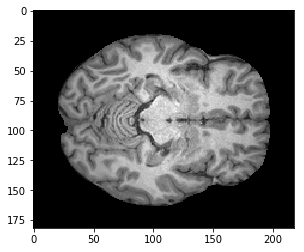

In [20]:
plt.imshow(img[0][:,:,60], cmap='gray')

In [21]:
sample["label"]

tensor([1.])

# Define the classifier

In [22]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([15,19,15],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=6,
                                            overlap=1,
                                            reassemble=False,
                                            debug=False)

        self.classifier_scratch = nn.Sequential(
            nn.Linear(7776, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)    
        h = F.elu(self.pif(x))
    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [23]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [24]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 1348665


# Training

In [25]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        
        # split train/validation
        train_df = data.sample(frac=0.8, random_state=32)
        val_df = data[~data["PTID"].isin(train_df["PTID"])]

        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        train_loader = DataLoader(
            ukb_data_train, batch_size=b, shuffle=True, num_workers=4
        )

        val_loader = DataLoader(
            ukb_data_val, batch_size=2, shuffle=True, num_workers=2
        )

        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=5,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models

In [26]:
num_epochs = 200
min_iters = 3
ignore_epochs = 15
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [27]:
r = 3

In [28]:
output_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/20_percent/experiment/"
callbacks = [EarlyStopping(patience=10, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
[0,     5] loss: 0.69840
[0,    10] loss: 0.68808
[0,    15] loss: 0.68975
Time elapsed: 0h:0m:24s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.718318
[1,     5] loss: 0.69432
[1,    10] loss: 0.68992
[1,    15] loss: 0.67224
Time elapsed: 0h:1m:0s
train accuracy_score: 56.30 %
train balanced_accuracy: 49.97 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.709093
[2,     5] loss: 0.67501
[2,    10] loss: 0.69763
[2,    15] loss: 0.68360
Time elapsed: 0h:1m:37s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.49 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.701781
[3,     5] loss: 0.70740
[3,    10] loss: 0.68019
[3,    15] loss: 0.68707
Time elapsed: 0h:2m:13s
train accuracy_score: 54.62 %
train balanced_accuracy: 48.26 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.708171
[4,     5] loss: 0.67564

[34,     5] loss: 0.66729
[34,    10] loss: 0.68507
[34,    15] loss: 0.64301
Time elapsed: 0h:20m:39s
train accuracy_score: 61.34 %
train balanced_accuracy: 57.87 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.689229
[35,     5] loss: 0.68360
[35,    10] loss: 0.64174
[35,    15] loss: 0.65340
Time elapsed: 0h:21m:17s
train accuracy_score: 61.34 %
train balanced_accuracy: 55.69 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702974
[36,     5] loss: 0.66961
[36,    10] loss: 0.70652
[36,    15] loss: 0.65157
Time elapsed: 0h:21m:51s
train accuracy_score: 57.98 %
train balanced_accuracy: 53.99 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.682090
[37,     5] loss: 0.67051
[37,    10] loss: 0.67274
[37,    15] loss: 0.64711
Time elapsed: 0h:22m:28s
train accuracy_score: 56.72 %
train balanced_accuracy: 52.53 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.689875
[38,     5] loss: 0.6627

val accuracy_score: 83.05 %
val balanced_accuracy: 82.32 %
Val loss: 0.328394
[68,     5] loss: 0.31671
[68,    10] loss: 0.20910
[68,    15] loss: 0.19560
Time elapsed: 0h:40m:56s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.13 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.79 %
Val loss: 0.304773
[69,     5] loss: 0.25064
[69,    10] loss: 0.21828
[69,    15] loss: 0.27113
Time elapsed: 0h:41m:32s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.85 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.31 %
Val loss: 0.364892
[70,     5] loss: 0.23018
[70,    10] loss: 0.20809
[70,    15] loss: 0.23780
Time elapsed: 0h:42m:7s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.70 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.89 %
Val loss: 0.309515
[71,     5] loss: 0.28799
[71,    10] loss: 0.16483
[71,    15] loss: 0.21564
Time elapsed: 0h:42m:44s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.44 %
val accuracy_score: 84.75

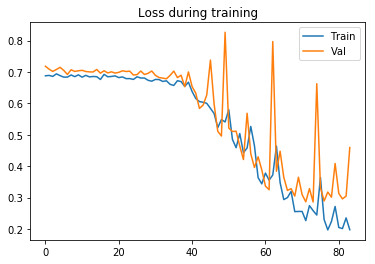

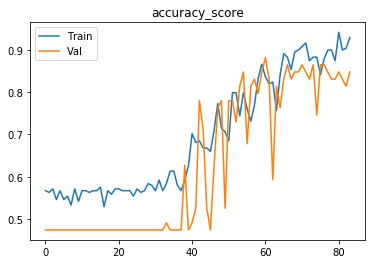

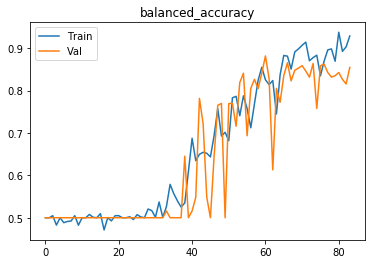

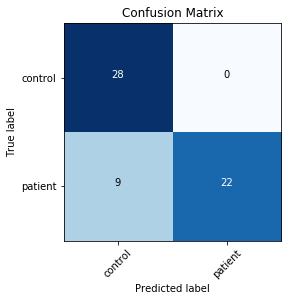

Starting trial 1
[0,     5] loss: 0.69625
[0,    10] loss: 0.69179
[0,    15] loss: 0.68525
Time elapsed: 0h:0m:25s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.703628
[1,     5] loss: 0.70372
[1,    10] loss: 0.67026
[1,    15] loss: 0.66900
Time elapsed: 0h:1m:0s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.712331
[2,     5] loss: 0.68451
[2,    10] loss: 0.67641
[2,    15] loss: 0.69364
Time elapsed: 0h:1m:35s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.706460
[3,     5] loss: 0.68184
[3,    10] loss: 0.68962
[3,    15] loss: 0.70676
Time elapsed: 0h:2m:12s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.698572
[4,     5] loss: 0.67234

[34,     5] loss: 0.38698
[34,    10] loss: 0.49004
[34,    15] loss: 0.45266
Time elapsed: 0h:20m:51s
train accuracy_score: 80.67 %
train balanced_accuracy: 79.51 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.86 %
Val loss: 0.488990
[35,     5] loss: 0.59022
[35,    10] loss: 0.36304
[35,    15] loss: 0.40324
Time elapsed: 0h:21m:26s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.00 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.36 %
Val loss: 0.450044
[36,     5] loss: 0.43856
[36,    10] loss: 0.39491
[36,    15] loss: 0.48340
Time elapsed: 0h:22m:1s
train accuracy_score: 83.61 %
train balanced_accuracy: 82.68 %
val accuracy_score: 79.66 %
val balanced_accuracy: 80.13 %
Val loss: 0.413915
[37,     5] loss: 0.35119
[37,    10] loss: 0.50473
[37,    15] loss: 0.38358
Time elapsed: 0h:22m:36s
train accuracy_score: 80.25 %
train balanced_accuracy: 79.37 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.29 %
Val loss: 0.435894
[38,     5] loss: 0.43886

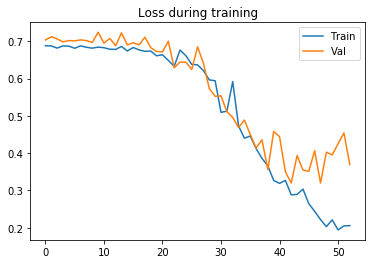

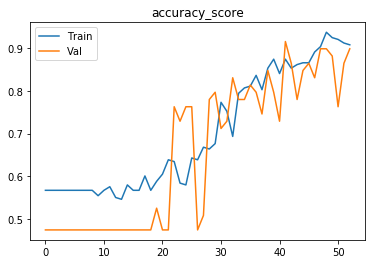

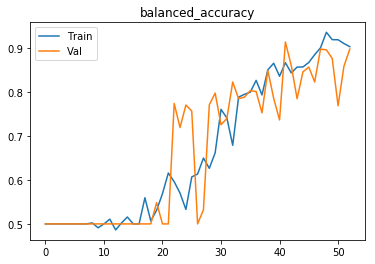

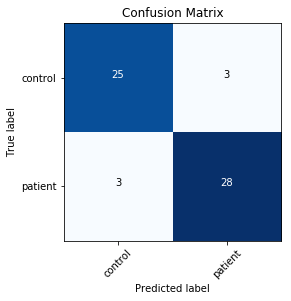

Starting trial 2
[0,     5] loss: 0.68834
[0,    10] loss: 0.70710
[0,    15] loss: 0.69337
Time elapsed: 0h:0m:25s
train accuracy_score: 52.94 %
train balanced_accuracy: 47.47 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.699866
[1,     5] loss: 0.67662
[1,    10] loss: 0.70092
[1,    15] loss: 0.69659
Time elapsed: 0h:1m:0s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700799
[2,     5] loss: 0.67880
[2,    10] loss: 0.66318
[2,    15] loss: 0.71097
Time elapsed: 0h:1m:35s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.701767
[3,     5] loss: 0.69585
[3,    10] loss: 0.69245
[3,    15] loss: 0.67971
Time elapsed: 0h:2m:10s
train accuracy_score: 53.36 %
train balanced_accuracy: 48.88 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.711756
[4,     5] loss: 0.68818

[34,     5] loss: 0.64760
[34,    10] loss: 0.63735
[34,    15] loss: 0.64909
Time elapsed: 0h:20m:31s
train accuracy_score: 65.55 %
train balanced_accuracy: 62.84 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.687959
[35,     5] loss: 0.65917
[35,    10] loss: 0.60778
[35,    15] loss: 0.57677
Time elapsed: 0h:21m:8s
train accuracy_score: 62.18 %
train balanced_accuracy: 56.66 %
val accuracy_score: 69.49 %
val balanced_accuracy: 70.79 %
Val loss: 0.630039
[36,     5] loss: 0.63834
[36,    10] loss: 0.62676
[36,    15] loss: 0.58685
Time elapsed: 0h:21m:43s
train accuracy_score: 68.49 %
train balanced_accuracy: 67.27 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.662162
[37,     5] loss: 0.61272
[37,    10] loss: 0.59236
[37,    15] loss: 0.60173
Time elapsed: 0h:22m:20s
train accuracy_score: 68.91 %
train balanced_accuracy: 67.30 %
val accuracy_score: 64.41 %
val balanced_accuracy: 65.96 %
Val loss: 0.607521
[38,     5] loss: 0.47684

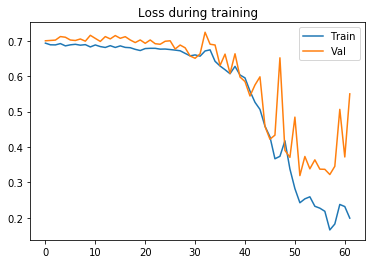

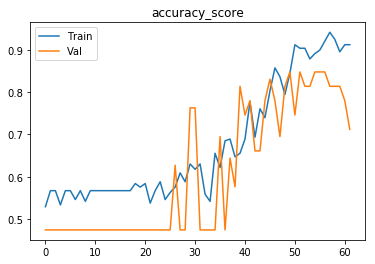

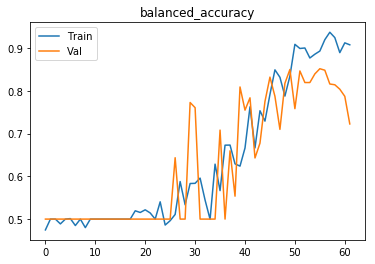

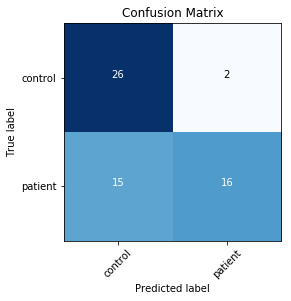

Starting trial 3
[0,     5] loss: 0.68637
[0,    10] loss: 0.69134
[0,    15] loss: 0.70924
Time elapsed: 0h:0m:25s
train accuracy_score: 53.78 %
train balanced_accuracy: 50.86 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.693586
[1,     5] loss: 0.70588
[1,    10] loss: 0.69528
[1,    15] loss: 0.71830
Time elapsed: 0h:1m:0s
train accuracy_score: 52.94 %
train balanced_accuracy: 48.39 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.698215
[2,     5] loss: 0.66939
[2,    10] loss: 0.70493
[2,    15] loss: 0.70059
Time elapsed: 0h:1m:36s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702039
[3,     5] loss: 0.69559
[3,    10] loss: 0.68450
[3,    15] loss: 0.66978
Time elapsed: 0h:2m:11s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.720622
[4,     5] loss: 0.69143

[34,     5] loss: 0.64824
[34,    10] loss: 0.67484
[34,    15] loss: 0.62881
Time elapsed: 0h:20m:29s
train accuracy_score: 59.24 %
train balanced_accuracy: 53.72 %
val accuracy_score: 50.85 %
val balanced_accuracy: 53.05 %
Val loss: 0.660476
[35,     5] loss: 0.63553
[35,    10] loss: 0.59761
[35,    15] loss: 0.65343
Time elapsed: 0h:21m:5s
train accuracy_score: 66.39 %
train balanced_accuracy: 62.43 %
val accuracy_score: 71.19 %
val balanced_accuracy: 71.72 %
Val loss: 0.634092
[36,     5] loss: 0.62484
[36,    10] loss: 0.63566
[36,    15] loss: 0.61417
Time elapsed: 0h:21m:40s
train accuracy_score: 64.29 %
train balanced_accuracy: 60.81 %
val accuracy_score: 69.49 %
val balanced_accuracy: 69.41 %
Val loss: 0.609312
[37,     5] loss: 0.60896
[37,    10] loss: 0.59881
[37,    15] loss: 0.64097
Time elapsed: 0h:22m:16s
train accuracy_score: 68.07 %
train balanced_accuracy: 66.33 %
val accuracy_score: 69.49 %
val balanced_accuracy: 68.38 %
Val loss: 0.588375
[38,     5] loss: 0.65403

val accuracy_score: 89.83 %
val balanced_accuracy: 89.80 %
Val loss: 0.256510
[68,     5] loss: 0.14594
[68,    10] loss: 0.22111
[68,    15] loss: 0.25009
Time elapsed: 0h:40m:55s
train accuracy_score: 89.92 %
train balanced_accuracy: 90.08 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.80 %
Val loss: 0.237620
[69,     5] loss: 0.23880
[69,    10] loss: 0.28735
[69,    15] loss: 0.19801
Time elapsed: 0h:41m:30s
train accuracy_score: 91.18 %
train balanced_accuracy: 90.96 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.29 %
Val loss: 0.281181
[70,     5] loss: 0.20677
[70,    10] loss: 0.16919
[70,    15] loss: 0.19365
Time elapsed: 0h:42m:4s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.30 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.07 %
Val loss: 0.257273
[71,     5] loss: 0.22420
[71,    10] loss: 0.26891
[71,    15] loss: 0.31453
Time elapsed: 0h:42m:40s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.13 %
val accuracy_score: 84.75

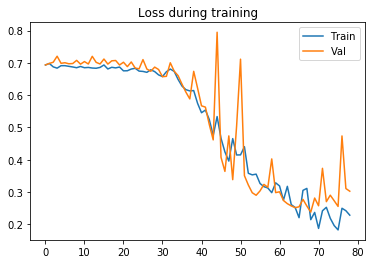

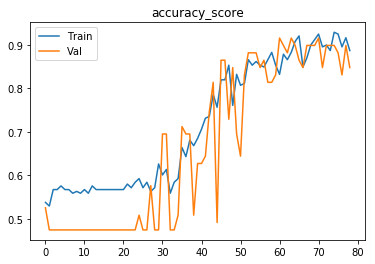

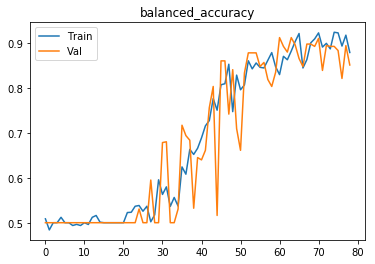

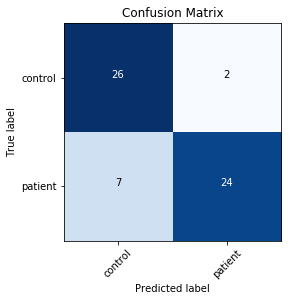

Starting trial 4
[0,     5] loss: 0.67893
[0,    10] loss: 0.75036
[0,    15] loss: 0.67043
Time elapsed: 0h:0m:24s
train accuracy_score: 55.46 %
train balanced_accuracy: 49.58 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696999
[1,     5] loss: 0.67924
[1,    10] loss: 0.70324
[1,    15] loss: 0.69385
Time elapsed: 0h:1m:1s
train accuracy_score: 55.88 %
train balanced_accuracy: 49.83 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.697177
[2,     5] loss: 0.67941
[2,    10] loss: 0.66002
[2,    15] loss: 0.69234
Time elapsed: 0h:1m:37s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.704904
[3,     5] loss: 0.67815
[3,    10] loss: 0.67826
[3,    15] loss: 0.69714
Time elapsed: 0h:2m:12s
train accuracy_score: 57.98 %
train balanced_accuracy: 51.46 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702675
[4,     5] loss: 0.68578

[34,     5] loss: 0.70011
[34,    10] loss: 0.67170
[34,    15] loss: 0.63883
Time elapsed: 0h:20m:54s
train accuracy_score: 56.72 %
train balanced_accuracy: 53.68 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.759002
[35,     5] loss: 0.65203
[35,    10] loss: 0.68592
[35,    15] loss: 0.65478
Time elapsed: 0h:21m:31s
train accuracy_score: 59.24 %
train balanced_accuracy: 52.91 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.673495
[36,     5] loss: 0.67545
[36,    10] loss: 0.67297
[36,    15] loss: 0.68260
Time elapsed: 0h:22m:8s
train accuracy_score: 58.40 %
train balanced_accuracy: 53.09 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.680626
[37,     5] loss: 0.66723
[37,    10] loss: 0.66826
[37,    15] loss: 0.66006
Time elapsed: 0h:22m:45s
train accuracy_score: 63.03 %
train balanced_accuracy: 60.50 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.695077
[38,     5] loss: 0.63670

val accuracy_score: 86.44 %
val balanced_accuracy: 85.71 %
Val loss: 0.460776
[68,     5] loss: 0.19644
[68,    10] loss: 0.21097
[68,    15] loss: 0.18634
Time elapsed: 0h:41m:34s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.59 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.71 %
Val loss: 0.404323
[69,     5] loss: 0.29170
[69,    10] loss: 0.34229
[69,    15] loss: 0.20513
Time elapsed: 0h:42m:10s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.45 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.97 %
Val loss: 0.322547
[70,     5] loss: 0.18161
[70,    10] loss: 0.22604
[70,    15] loss: 0.13396
Time elapsed: 0h:42m:46s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.15 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.71 %
Val loss: 0.456167
[71,     5] loss: 0.21008
[71,    10] loss: 0.15046
[71,    15] loss: 0.19005
Time elapsed: 0h:43m:22s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.30 %
val accuracy_score: 81.3

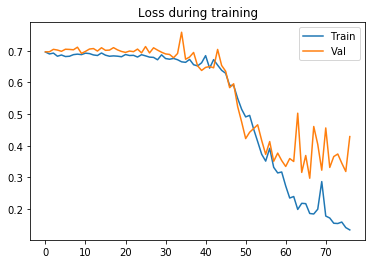

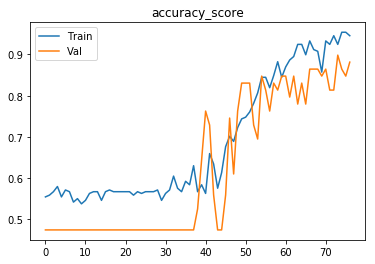

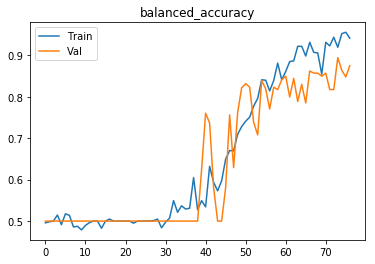

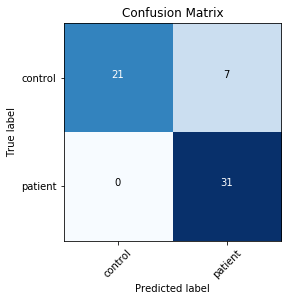

Starting trial 5
[0,     5] loss: 0.69342
[0,    10] loss: 0.68281
[0,    15] loss: 0.70325
Time elapsed: 0h:0m:26s
train accuracy_score: 53.36 %
train balanced_accuracy: 48.88 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.708731
[1,     5] loss: 0.70116
[1,    10] loss: 0.68793
[1,    15] loss: 0.66472
Time elapsed: 0h:1m:1s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.715688
[2,     5] loss: 0.71260
[2,    10] loss: 0.67539
[2,    15] loss: 0.69325
Time elapsed: 0h:1m:37s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700378
[3,     5] loss: 0.68538
[3,    10] loss: 0.69453
[3,    15] loss: 0.70290
Time elapsed: 0h:2m:14s
train accuracy_score: 56.30 %
train balanced_accuracy: 49.63 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.705080
[4,     5] loss: 0.69018

[34,     5] loss: 0.58083
[34,    10] loss: 0.58416
[34,    15] loss: 0.63166
Time elapsed: 0h:21m:4s
train accuracy_score: 65.97 %
train balanced_accuracy: 65.86 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.775962
[35,     5] loss: 0.60045
[35,    10] loss: 0.61073
[35,    15] loss: 0.55120
Time elapsed: 0h:21m:41s
train accuracy_score: 69.33 %
train balanced_accuracy: 66.86 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.48 %
Val loss: 0.560603
[36,     5] loss: 0.55975
[36,    10] loss: 0.58731
[36,    15] loss: 0.57364
Time elapsed: 0h:22m:18s
train accuracy_score: 73.95 %
train balanced_accuracy: 72.55 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.45 %
Val loss: 0.538963
[37,     5] loss: 0.62941
[37,    10] loss: 0.55498
[37,    15] loss: 0.52066
Time elapsed: 0h:22m:54s
train accuracy_score: 71.43 %
train balanced_accuracy: 69.41 %
val accuracy_score: 64.41 %
val balanced_accuracy: 66.13 %
Val loss: 0.575192
[38,     5] loss: 0.50234

val accuracy_score: 89.83 %
val balanced_accuracy: 89.46 %
Val loss: 0.329006
[68,     5] loss: 0.15783
[68,    10] loss: 0.09374
[68,    15] loss: 0.09320
Time elapsed: 0h:41m:48s
train accuracy_score: 94.12 %
train balanced_accuracy: 93.89 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.46 %
Val loss: 0.311752
[69,     5] loss: 0.19476
[69,    10] loss: 0.15923
[69,    15] loss: 0.15149
Time elapsed: 0h:42m:25s
train accuracy_score: 96.22 %
train balanced_accuracy: 96.09 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.71 %
Val loss: 0.378772
Early stopping in epoch 70
Total time elapsed: 0h:42m:36s
Writing model to disk...
Best result during training: 0.93. Saving model..
Finished fold.


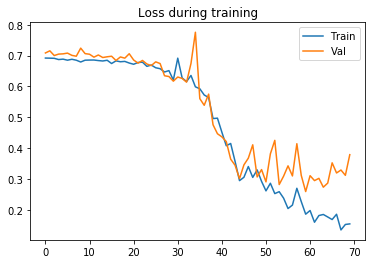

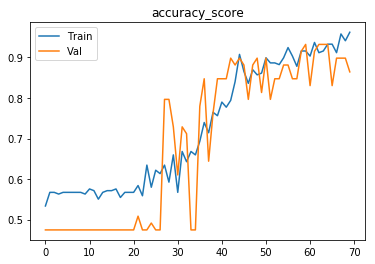

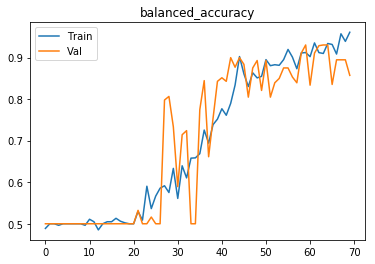

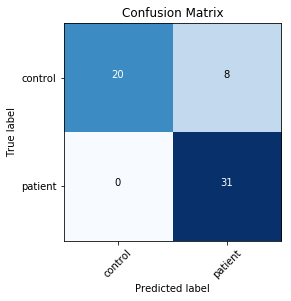

Starting trial 6
[0,     5] loss: 0.71535
[0,    10] loss: 0.68711
[0,    15] loss: 0.69416
Time elapsed: 0h:0m:26s
train accuracy_score: 54.20 %
train balanced_accuracy: 53.30 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.718423
[1,     5] loss: 0.69246
[1,    10] loss: 0.69746
[1,    15] loss: 0.69113
Time elapsed: 0h:1m:2s
train accuracy_score: 53.36 %
train balanced_accuracy: 48.88 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.699907
[2,     5] loss: 0.69283
[2,    10] loss: 0.69517
[2,    15] loss: 0.67436
Time elapsed: 0h:1m:39s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.720509
[3,     5] loss: 0.70832
[3,    10] loss: 0.69702
[3,    15] loss: 0.68929
Time elapsed: 0h:2m:15s
train accuracy_score: 53.36 %
train balanced_accuracy: 47.96 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696380
[4,     5] loss: 0.68162

[34,     5] loss: 0.66939
[34,    10] loss: 0.64250
[34,    15] loss: 0.67488
Time elapsed: 0h:21m:7s
train accuracy_score: 59.24 %
train balanced_accuracy: 53.26 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.677835
[35,     5] loss: 0.66818
[35,    10] loss: 0.65671
[35,    15] loss: 0.65153
Time elapsed: 0h:21m:45s
train accuracy_score: 58.40 %
train balanced_accuracy: 53.21 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.666982
[36,     5] loss: 0.64707
[36,    10] loss: 0.65475
[36,    15] loss: 0.65056
Time elapsed: 0h:22m:21s
train accuracy_score: 63.87 %
train balanced_accuracy: 60.90 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.61 %
Val loss: 0.665435
[37,     5] loss: 0.63816
[37,    10] loss: 0.62294
[37,    15] loss: 0.66270
Time elapsed: 0h:22m:58s
train accuracy_score: 60.92 %
train balanced_accuracy: 56.47 %
val accuracy_score: 71.19 %
val balanced_accuracy: 69.82 %
Val loss: 0.641990
[38,     5] loss: 0.62667

val accuracy_score: 81.36 %
val balanced_accuracy: 80.88 %
Val loss: 0.289997
[68,     5] loss: 0.28501
[68,    10] loss: 0.24390
[68,    15] loss: 0.24464
Time elapsed: 0h:41m:36s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.67 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.87 %
Val loss: 0.350166
[69,     5] loss: 0.36013
[69,    10] loss: 0.28314
[69,    15] loss: 0.22348
Time elapsed: 0h:42m:12s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.33 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.88 %
Val loss: 0.268599
[70,     5] loss: 0.22045
[70,    10] loss: 0.34544
[70,    15] loss: 0.26874
Time elapsed: 0h:42m:48s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.19 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.02 %
Val loss: 0.266999
[71,     5] loss: 0.17137
[71,    10] loss: 0.32197
[71,    15] loss: 0.32412
Time elapsed: 0h:43m:26s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.56 %
val accuracy_score: 76.2

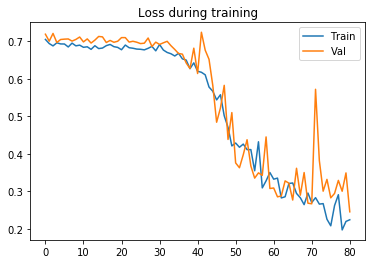

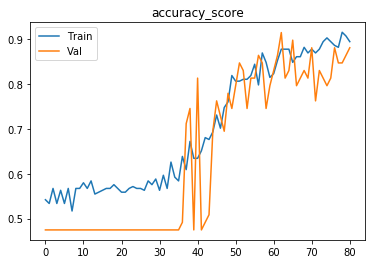

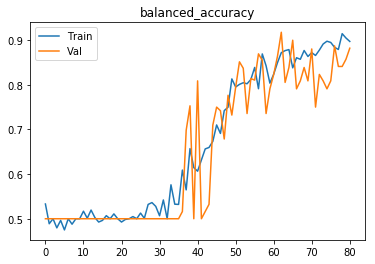

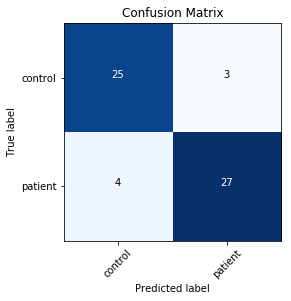

Starting trial 7
[0,     5] loss: 0.69247
[0,    10] loss: 0.70323
[0,    15] loss: 0.68670
Time elapsed: 0h:0m:26s
train accuracy_score: 55.88 %
train balanced_accuracy: 49.83 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.701591
[1,     5] loss: 0.67187
[1,    10] loss: 0.68155
[1,    15] loss: 0.69608
Time elapsed: 0h:1m:2s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.705227
[2,     5] loss: 0.70377
[2,    10] loss: 0.68400
[2,    15] loss: 0.69381
Time elapsed: 0h:1m:39s
train accuracy_score: 55.88 %
train balanced_accuracy: 49.26 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.698358
[3,     5] loss: 0.67832
[3,    10] loss: 0.67043
[3,    15] loss: 0.74588
Time elapsed: 0h:2m:17s
train accuracy_score: 56.30 %
train balanced_accuracy: 49.63 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.695298
[4,     5] loss: 0.68860

[34,     5] loss: 0.62488
[34,    10] loss: 0.60358
[34,    15] loss: 0.64070
Time elapsed: 0h:21m:8s
train accuracy_score: 60.92 %
train balanced_accuracy: 57.16 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.21 %
Val loss: 0.618387
[35,     5] loss: 0.63627
[35,    10] loss: 0.53730
[35,    15] loss: 0.63351
Time elapsed: 0h:21m:44s
train accuracy_score: 68.91 %
train balanced_accuracy: 66.38 %
val accuracy_score: 67.80 %
val balanced_accuracy: 68.66 %
Val loss: 0.597929
[36,     5] loss: 0.60722
[36,    10] loss: 0.65714
[36,    15] loss: 0.56839
Time elapsed: 0h:22m:22s
train accuracy_score: 68.49 %
train balanced_accuracy: 65.66 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.82 %
Val loss: 0.575637
[37,     5] loss: 0.55102
[37,    10] loss: 0.57628
[37,    15] loss: 0.58605
Time elapsed: 0h:22m:58s
train accuracy_score: 71.85 %
train balanced_accuracy: 70.24 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.34 %
Val loss: 0.531046
[38,     5] loss: 0.57348

val accuracy_score: 83.05 %
val balanced_accuracy: 83.01 %
Val loss: 0.349671
[68,     5] loss: 0.13082
[68,    10] loss: 0.12842
[68,    15] loss: 0.14518
Time elapsed: 0h:41m:42s
train accuracy_score: 94.54 %
train balanced_accuracy: 94.61 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.50 %
Val loss: 0.438306
[69,     5] loss: 0.17189
[69,    10] loss: 0.27039
[69,    15] loss: 0.11586
Time elapsed: 0h:42m:21s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.78 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.53 %
Val loss: 0.414080
Early stopping in epoch 70
Total time elapsed: 0h:42m:31s
Writing model to disk...
Best result during training: 0.91. Saving model..
Finished fold.


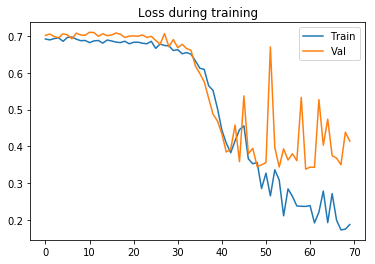

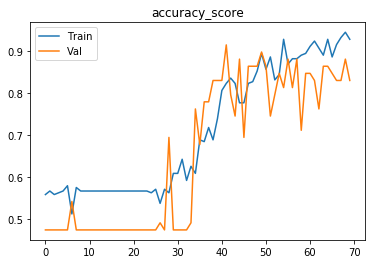

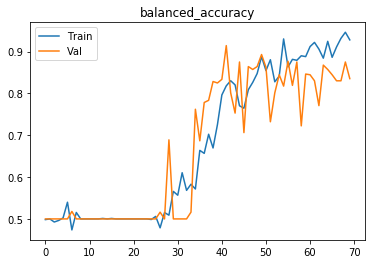

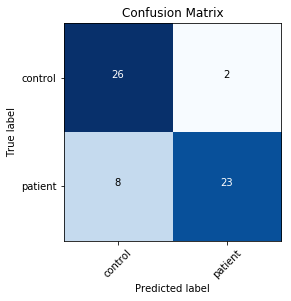

Starting trial 8
[0,     5] loss: 0.69765
[0,    10] loss: 0.69273
[0,    15] loss: 0.68841
Time elapsed: 0h:0m:24s
train accuracy_score: 54.62 %
train balanced_accuracy: 51.72 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.719891
[1,     5] loss: 0.70343
[1,    10] loss: 0.69088
[1,    15] loss: 0.69056
Time elapsed: 0h:1m:0s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.12 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.716090
[2,     5] loss: 0.67211
[2,    10] loss: 0.66727
[2,    15] loss: 0.67905
Time elapsed: 0h:1m:37s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.695768
[3,     5] loss: 0.70891
[3,    10] loss: 0.68288
[3,    15] loss: 0.69334
Time elapsed: 0h:2m:13s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.46 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700584
[4,     5] loss: 0.69528

[34,     5] loss: 0.63084
[34,    10] loss: 0.66052
[34,    15] loss: 0.64036
Time elapsed: 0h:21m:2s
train accuracy_score: 65.97 %
train balanced_accuracy: 64.94 %
val accuracy_score: 52.54 %
val balanced_accuracy: 54.84 %
Val loss: 0.639482
[35,     5] loss: 0.55594
[35,    10] loss: 0.66455
[35,    15] loss: 0.64244
Time elapsed: 0h:21m:40s
train accuracy_score: 63.03 %
train balanced_accuracy: 61.19 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.29 %
Val loss: 0.593930
[36,     5] loss: 0.60824
[36,    10] loss: 0.57133
[36,    15] loss: 0.53315
Time elapsed: 0h:22m:16s
train accuracy_score: 72.27 %
train balanced_accuracy: 69.80 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.25 %
Val loss: 0.583711
[37,     5] loss: 0.51944
[37,    10] loss: 0.57283
[37,    15] loss: 0.55803
Time elapsed: 0h:22m:51s
train accuracy_score: 74.37 %
train balanced_accuracy: 72.46 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.53 %
Val loss: 0.534598
[38,     5] loss: 0.67950

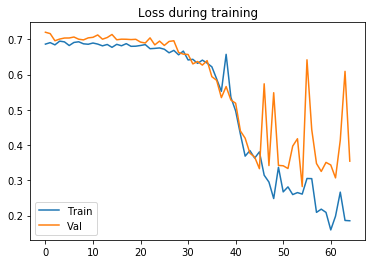

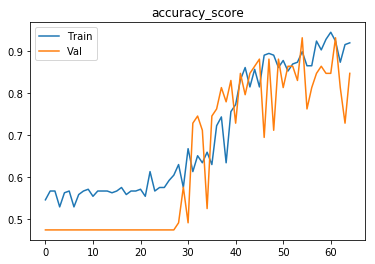

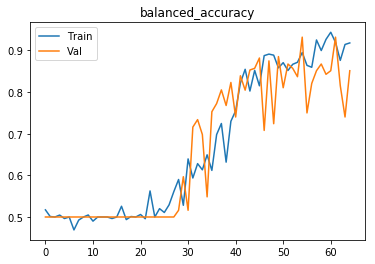

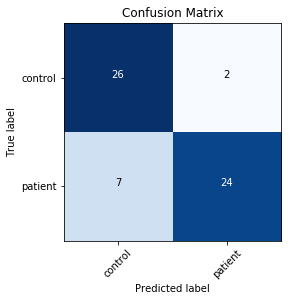

Starting trial 9
[0,     5] loss: 0.68183
[0,    10] loss: 0.68926
[0,    15] loss: 0.71182
Time elapsed: 0h:0m:25s
train accuracy_score: 56.30 %
train balanced_accuracy: 51.70 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.699426
[1,     5] loss: 0.69124
[1,    10] loss: 0.69871
[1,    15] loss: 0.68247
Time elapsed: 0h:1m:3s
train accuracy_score: 56.30 %
train balanced_accuracy: 49.63 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702945
[2,     5] loss: 0.68503
[2,    10] loss: 0.71664
[2,    15] loss: 0.68087
Time elapsed: 0h:1m:38s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702298
[3,     5] loss: 0.69440
[3,    10] loss: 0.68697
[3,    15] loss: 0.68136
Time elapsed: 0h:2m:14s
train accuracy_score: 55.88 %
train balanced_accuracy: 49.26 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.708495
[4,     5] loss: 0.69147

[34,     5] loss: 0.65176
[34,    10] loss: 0.64556
[34,    15] loss: 0.63307
Time elapsed: 0h:21m:5s
train accuracy_score: 62.61 %
train balanced_accuracy: 59.67 %
val accuracy_score: 57.63 %
val balanced_accuracy: 59.68 %
Val loss: 0.647421
[35,     5] loss: 0.64953
[35,    10] loss: 0.63185
[35,    15] loss: 0.59058
Time elapsed: 0h:21m:40s
train accuracy_score: 65.97 %
train balanced_accuracy: 62.52 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.42 %
Val loss: 0.613815
[36,     5] loss: 0.53779
[36,    10] loss: 0.76222
[36,    15] loss: 0.62422
Time elapsed: 0h:22m:16s
train accuracy_score: 61.34 %
train balanced_accuracy: 59.48 %
val accuracy_score: 71.19 %
val balanced_accuracy: 71.72 %
Val loss: 0.610817
[37,     5] loss: 0.62601
[37,    10] loss: 0.65036
[37,    15] loss: 0.61878
Time elapsed: 0h:22m:52s
train accuracy_score: 68.91 %
train balanced_accuracy: 66.03 %
val accuracy_score: 71.19 %
val balanced_accuracy: 72.06 %
Val loss: 0.596176
[38,     5] loss: 0.61849

val accuracy_score: 83.05 %
val balanced_accuracy: 83.70 %
Val loss: 0.318172
[68,     5] loss: 0.21925
[68,    10] loss: 0.15798
[68,    15] loss: 0.18395
Time elapsed: 0h:41m:39s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.04 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.29 %
Val loss: 0.250611
[69,     5] loss: 0.18628
[69,    10] loss: 0.09633
[69,    15] loss: 0.16665
Time elapsed: 0h:42m:14s
train accuracy_score: 94.12 %
train balanced_accuracy: 94.12 %
val accuracy_score: 71.19 %
val balanced_accuracy: 72.41 %
Val loss: 0.536629
[70,     5] loss: 0.22905
[70,    10] loss: 0.24433
[70,    15] loss: 0.38788
Time elapsed: 0h:42m:50s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.53 %
val accuracy_score: 84.75 %
val balanced_accuracy: 83.93 %
Val loss: 0.440103
[71,     5] loss: 0.13834
[71,    10] loss: 0.17698
[71,    15] loss: 0.14660
Time elapsed: 0h:43m:26s
train accuracy_score: 94.12 %
train balanced_accuracy: 93.66 %
val accuracy_score: 88.1

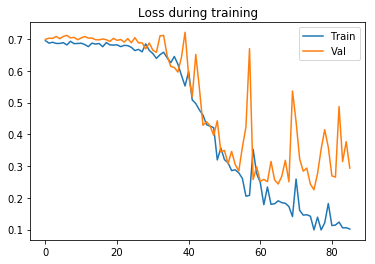

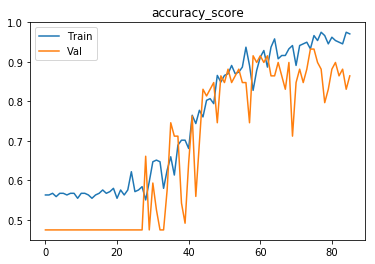

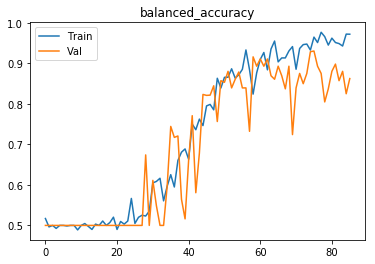

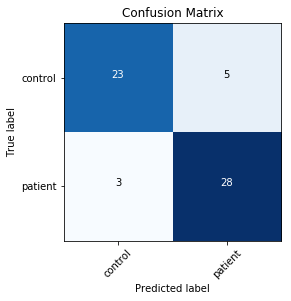

################################
################################
All accuracies: [0.8548387096774194, 0.898041474654378, 0.7223502304147466, 0.8513824884792627, 0.875, 0.8571428571428572, 0.8819124423963134, 0.8352534562211982, 0.8513824884792627, 0.8623271889400921]
0.848963133640553
0.045478320365027865


In [29]:
fold_metric, models = run(net=net, data=train_df,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  augmentations=augmentations,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [30]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [31]:
if zero_one_normalize:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
else:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
            
test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [32]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [33]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))

Fold 0
0.8600732600732601
Fold 1
0.8472527472527474
Fold 2
0.8443223443223443
Fold 3
0.9186813186813187
Fold 4
0.9087912087912088
Fold 5
0.9201465201465202
Fold 6
0.83003663003663
Fold 7
0.9058608058608059
Fold 8
0.9172161172161172
Fold 9
0.8886446886446886
######## Final results ########
          0
0  0.860073
1  0.847253
2  0.844322
3  0.918681
4  0.908791
5  0.920147
6  0.830037
7  0.905861
8  0.917216
9  0.888645
Balanced accuracy mean 88.41 %
